In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split, Subset
from torch import optim
from torchvision.datasets import SVHN, MNIST
from tqdm import tqdm

from src.data_utils import (
    TransformDataset,
    SrcDataset,
    SSDADatasetWithoutLabel, # 旧DstDatasetにあたる
    SSDADatasetWithLabel,
    get_train_weak_transform,
    get_train_strong_transform,
    get_test_transform,
    get_unlabeled_and_labeled_indices,
)
from src.models import get_model
from src.reproducibility import set_seed
from src.loss import consistency_loss

In [2]:
# 入力画像サイズ
INPUT_SIZE = 32

# バッチサイズ
BATCH_SIZE = 32

# learning rate
# VIT_LR = 5e-5
# CNN_LR = 0.01
VIT_LR = 0.001
CNN_LR = 0.01


# Co training時の閾値
TH_CNN = 0.9
TH_VIT = 0.6

# 検証のステップ数
TEST_INTERVAL = 500

# 総ステップ数
ADAPT_ITERS = 5000

# Normalize時のmean, std
NORMALIZE_MEAN = 0.5
NORMALIZE_STD = 0.5

# ssdaで使用する各ラベルの数
NUM_SSDA_DATA_PER_LABEL = 32 # 32 x 10ラベル = 320枚

# シード値
SEED = 2024

In [3]:
def get_source_dl(batch_size=BATCH_SIZE):
    weak_trans = get_train_weak_transform()
    test_trans = get_test_transform()
    train_mnist = MNIST(
        root='./mnist/',
        train=True,
        download=True,
    )
    test_mnist = MNIST(
        root='./mnist/',
        train=False,
        download=True,
        transform=test_trans
    )
    split_generator = torch.Generator().manual_seed(SEED)
    train_mnist, valid_mnist = random_split(train_mnist, [0.8, 0.2], split_generator)
    train_mnist = SrcDataset(
        train_mnist,
        weak_trans,
    )
    valid_mnist = TransformDataset(
        valid_mnist,
        test_trans
    )
    dl_generator = torch.Generator().manual_seed(SEED)
    src_train_dl = DataLoader(
        train_mnist,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        generator=dl_generator,
        drop_last=True,
    )
    src_valid_dl = DataLoader(
        valid_mnist,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )
    src_test_dl = DataLoader(
        test_mnist,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )
    return src_train_dl, src_valid_dl, src_test_dl


def get_target_dl(batch_size=BATCH_SIZE):
    weak_trans, strong_trans = get_train_weak_transform(), get_train_strong_transform(v=8)
    test_trans = get_test_transform()
    loaded_train_svhm = SVHN(
        root='./svhm/',
        split='train',
        download=True,
    )
    loeaded_test_svhm = SVHN(
        root='./svhm/',
        split='test',
        download=True,
        transform=test_trans,
    )
    # データを画像とラベルに分離する
    X_train_loaded, y_train_loaded = loaded_train_svhm.data, loaded_train_svhm.labels
    X_test, y_test = loeaded_test_svhm.data, loeaded_test_svhm.labels
    # 全データ -> 学習用データ, 検証用データに分割
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_loaded,
        y_train_loaded,
        shuffle=True,
        stratify=y_train_loaded,
        random_state=SEED
    )
    # ラベル無しとありのデータインデックスを取得
    unlabeled_indices, labeled_indices = get_unlabeled_and_labeled_indices(
        y_train,
        num_labeled_indices_per_label=NUM_SSDA_DATA_PER_LABEL,
        seed=SEED
    )
    X_train_unlabeled, X_train_labeled, y_train = (
        X_train[unlabeled_indices],
        X_train[labeled_indices],
        y_train[labeled_indices]
    )
    assert len(X_train_labeled) == len(y_train)
    # train_ds
    train_unlabeled_ds = SSDADatasetWithoutLabel(
        X_train_unlabeled,
        weak_trans,
        strong_trans,
    )
    train_labeled_ds = SSDADatasetWithLabel(
        X_train_labeled,
        y_train,
        weak_trans,
    )
    # valid_ds
    valid_ds = SSDADatasetWithLabel(
        X_valid,
        y_valid,
        test_trans,
    )
    # test_ds
    test_ds = SSDADatasetWithLabel(
        X_test,
        y_test,
        test_trans,
    )
    # データローダー作成
    dl_generator = torch.Generator().manual_seed(SEED)
    dst_train_unlabeled_dl = DataLoader(
        train_unlabeled_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        generator=dl_generator,
        drop_last=True
    )
    dst_train_labeled_dl = DataLoader(
        train_labeled_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        generator=dl_generator,
        drop_last=True
    )
    dst_valid_dl = DataLoader(
        valid_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )
    dst_test_dl = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )
    return dst_train_unlabeled_dl, dst_train_labeled_dl, dst_valid_dl, dst_test_dl
    


In [4]:
src_train_dl, src_valid_dl, src_test_dl = get_source_dl()
dst_train_unlabeled_dl, dst_train_labeled_dl, dst_valid_dl, dst_test_dl = get_target_dl()

Using downloaded and verified file: ./svhm/train_32x32.mat
Using downloaded and verified file: ./svhm/test_32x32.mat


In [5]:
len(dst_train_unlabeled_dl), len(dst_train_labeled_dl)

(1713, 3)

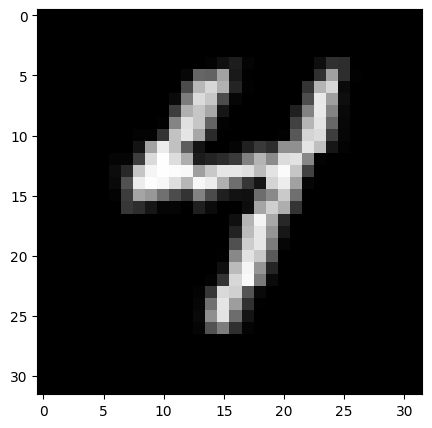

In [6]:
set_seed()
src_X_weak, src_y = next(iter(src_train_dl))
fig, ax = plt.subplots(figsize=(5, 5))
mean_tensor = torch.tensor(NORMALIZE_MEAN).unsqueeze(0).unsqueeze(0)
std_tensor = torch.tensor(NORMALIZE_STD).unsqueeze(0).unsqueeze(0)
idx = 0
ax.imshow(
    src_X_weak.permute(0, 2, 3, 1)[idx] * std_tensor +  mean_tensor
)
plt.show()

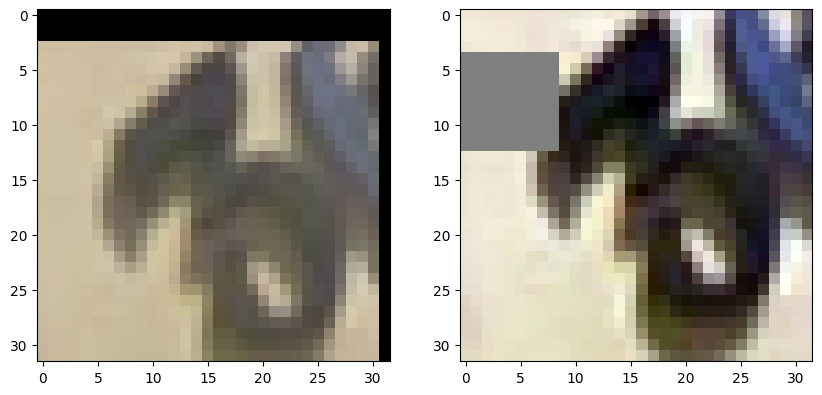

In [7]:
set_seed()
dst_X_weak, dst_X_strong = next(iter(dst_train_unlabeled_dl))
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
mean_tensor = torch.tensor(NORMALIZE_MEAN).unsqueeze(0).unsqueeze(0)
std_tensor = torch.tensor(NORMALIZE_STD).unsqueeze(0).unsqueeze(0)
idx = 30
axes[0].imshow(
    dst_X_weak.permute(0, 2, 3, 1)[idx] * std_tensor +  mean_tensor
)
axes[1].imshow(
    dst_X_strong.permute(0, 2, 3, 1)[idx] * std_tensor +  mean_tensor
)
plt.show()

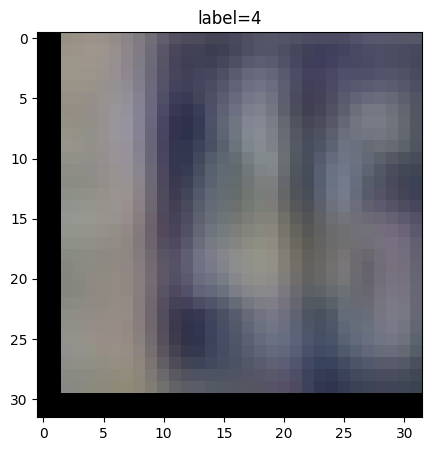

In [8]:
dst_X_weak_labeled, dst_labels = next(iter(dst_train_labeled_dl))
fig, ax = plt.subplots(figsize=(5, 5))
mean_tensor = torch.tensor(NORMALIZE_MEAN).unsqueeze(0).unsqueeze(0)
std_tensor = torch.tensor(NORMALIZE_STD).unsqueeze(0).unsqueeze(0)
idx = 0
ax.imshow(
    dst_X_weak_labeled.permute(0, 2, 3, 1)[idx] * std_tensor +  mean_tensor
)
ax.set_title(f'label={dst_labels[idx]}')
plt.show()

In [4]:
def get_cnn_and_vit_model():
    G1, F1 = get_model(model_type='vit', num_feature_extractor_out=512)
    G2, F2 = get_model(model_type='cnn', num_feature_extractor_out=512)
    return (G1, F1, G2, F2)


def inv_lr_scheduler(param_lr, optimizer, iter_num, gamma=0.0001,
                     power=0.75, init_lr=0.001):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (1 + gamma * iter_num) ** (- power)
    i = 0
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr * param_lr[i]
        i += 1
    return optimizer


def train(
    G1,
    F1,
    G2,
    F2,
    optimizer_g1,
    optimizer_f1,
    optimizer_g2,
    optimizer_f2,
    src_train_dl,
    src_valid_dl,
    dst_train_dl,
    dst_train_with_label_dl,
    dst_valid_dl,
    adapt_iter,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    ce_criterion = nn.CrossEntropyLoss()
    def zero_grad_all():
        optimizer_g1.zero_grad()
        optimizer_f1.zero_grad()
        optimizer_g2.zero_grad()
        optimizer_f2.zero_grad()

    len_src_dl = len(src_train_dl)
    len_dst_dl = len(dst_train_dl)
    len_dst_with_label_dl = len(dst_train_with_label_dl)

    param_lr_g1 = []
    for param_group in optimizer_g1.param_groups:
        param_lr_g1.append(param_group["lr"])
    param_lr_g2 = []
    for param_group in optimizer_g2.param_groups:
        param_lr_g2.append(param_group["lr"])
    param_lr_f1 = []
    for param_group in optimizer_f1.param_groups:
        param_lr_f1.append(param_group["lr"])
    param_lr_f2 = []
    for param_group in optimizer_f2.param_groups:
        param_lr_f2.append(param_group["lr"])
    for step in range(adapt_iter):
        optimizer_g1 = inv_lr_scheduler(
            param_lr_g1, optimizer_g1, step, init_lr=VIT_LR
        )
        optimizer_g2 = inv_lr_scheduler(
            param_lr_g2, optimizer_g2, step, init_lr=CNN_LR
        )
        optimizer_f1 = inv_lr_scheduler(param_lr_f1, optimizer_f1, step, init_lr=CNN_LR)
        optimizer_f2 = inv_lr_scheduler(param_lr_f2, optimizer_f2, step, init_lr=CNN_LR)

        G1.train()
        F1.train()
        G2.train()
        F2.train()
        if step % len_src_dl == 0:
            iter_src = iter(src_train_dl)
        if step % len_dst_dl == 0:
            iter_dst = iter(dst_train_dl)
        if step % len_dst_with_label_dl == 0:
            iter_dst_with_label = iter(dst_train_with_label_dl)
        # データ準備
        src_X_weak, src_y = next(iter_src)
        dst_X_weak, dst_X_strong = next(iter_dst)
        dst_X_weak_with_labeld, dst_y = next(iter_dst_with_label)
        src_X_weak = src_X_weak.to(device)
        src_y = src_y.to(device)
        dst_X_weak = dst_X_weak.to(device)
        dst_X_strong = dst_X_strong.to(device)
        dst_X_weak_with_labeld = dst_X_weak_with_labeld.to(device)
        dst_y = dst_y.to(device)

        labeled_targetw_tuple = [src_X_weak, dst_X_weak_with_labeld]
        labeled_gt = [src_y, dst_y]
        nl = src_X_weak.size(0) + dst_X_weak_with_labeld.size(0)

        labeled_targetw_input = torch.cat(
            labeled_targetw_tuple + [dst_X_weak],
            0
        )
        labeled_targetstr_input = torch.cat(
            labeled_targetw_tuple + [dst_X_strong],
            0
        )
        unlabeled_target_input = torch.cat(
            (dst_X_weak, dst_X_strong),
            0
        )
        labeled_input = torch.cat(labeled_targetw_tuple, 0)
        labeled_gt = torch.cat(labeled_gt, 0)

        zero_grad_all()
        # == 1. 教師あり学習実施 ==
        # 1.1 ViT
        vit_logits = F1(G1(labeled_input))
        vit_loss = ce_criterion(vit_logits, labeled_gt)

        vit_loss.backward()
        optimizer_g1.step()
        optimizer_f1.step()
        zero_grad_all()
        # 1.2 CNN
        cnn_logits = F2(G2(labeled_targetw_input))
        cnn_loss = ce_criterion(cnn_logits[:nl], labeled_gt)

        cnn_loss.backward()
        optimizer_g2.step()
        optimizer_f2.step()
        zero_grad_all()

        # 2. MCD
        # 2.1 Finding
        output_f1 = F1(G1(labeled_input))
        output_f2 = F2(G2(labeled_targetw_input))
        loss_f1 = ce_criterion(output_f1, labeled_gt)
        loss_f2 = ce_criterion(output_f2[:nl], labeled_gt)

        loss_s = loss_f1 + loss_f2

        vit_features_t = G1(unlabeled_target_input)
        output_t1 = F1(vit_features_t)
        output_t2 = F2(vit_features_t)
        loss_dis = torch.mean(
            torch.abs(
                F.softmax(output_t1, dim=1) - F.softmax(output_t2, dim=1)
            )
        )
        loss = loss_s - loss_dis
        loss.backward()
        optimizer_f1.step()
        optimizer_f2.step()
        zero_grad_all()

        # 2. Conquering
        for _ in range(4):
            feat_t = G2(unlabeled_target_input)
            output_t1 = F1(feat_t)
            output_t2 = F2(feat_t)
            loss_dis = torch.mean(
                torch.abs(
                    F.softmax(output_t1, dim=1) - F.softmax(output_t2, dim=1)
                )
            )
            loss_dis.backward()
            optimizer_g2.step()
            zero_grad_all()

        # 3. co training
        # 3.1 ViT -> CNN
        vit_logits = F1(G1(dst_X_weak))
        logits_u_s = F2(G2(labeled_targetstr_input))
        loss_vit_to_cnn = consistency_loss(
            logits_u_s[nl:], vit_logits, threshold=TH_VIT
        )
        loss_vit_to_cnn.backward()
        optimizer_g2.step()
        optimizer_f2.step()
        zero_grad_all()

        # # 3.2 CNN -> ViT
        logits_u_s = F1(G1(dst_X_strong))
        cnn_logits = F2(G2(labeled_targetw_input))
        loss_cnn_to_vit = consistency_loss(
            logits_u_s, cnn_logits[nl:], threshold=TH_CNN
        )
        loss_cnn_to_vit.backward()
        optimizer_g1.step()
        optimizer_f1.step()
        zero_grad_all()

        if step % 20 == 0 or step == adapt_iter -1:
            print(
                (
                    f'{step} / {adapt_iter} '
                    f'CNN loss={cnn_loss.item():.6f} ViT Loss={vit_loss.item():.6f} '
                    f'loss_vit_to_cnn={loss_vit_to_cnn.item():.6f} loss_cnn_to_vit={loss_cnn_to_vit.item():.6f}'
                )
            )

        if step % TEST_INTERVAL == 0 and step != 0:
            vit_src_acc, vit_src_loss = evaluate(
                G1,
                F1,
                ce_criterion,
                src_valid_dl,
                device,
            )
            cnn_src_acc, cnn_src_loss = evaluate(
                G2,
                F2,
                ce_criterion,
                src_valid_dl,
                device,
            )
            print('=== src ===')
            print(
                (
                    f'{step} / {adapt_iter} '
                    f'ViT acc={vit_src_acc:.6f} ViT Loss={vit_src_loss:.6f} '
                    f'CNN acc={cnn_src_acc:.6f} CNN Loss={cnn_src_loss:.6f}'
                )
            )
            vit_dst_acc, vit_dst_loss = evaluate(
                G1,
                F1,
                ce_criterion,
                dst_valid_dl,
                device,
            )
            cnn_dst_acc, cnn_dst_loss = evaluate(
                G2,
                F2,
                ce_criterion,
                dst_valid_dl,
                device,
            )
            print('=== dst ===')
            print(
                (
                    f'{step} / {adapt_iter} '
                    f'ViT acc={vit_dst_acc:.6f} ViT Loss={vit_dst_loss:.6f} '
                    f'CNN acc={cnn_dst_acc:.6f} CNN Loss={cnn_dst_loss:.6f}'
                )
            )


def train_normal(
    G,
    F,
    optimizer_G,
    optimizer_F,
    loss_fn,
    epochs,
    train_dl,
    valid_dl,
    device,
):
    logs = {
        'train_accuracy': [],
        'train_loss': [],
        'valid_accuracy': [],
        'valid_loss': [],
    }
    for epoch in range(epochs):
        train_accuracy, train_avg_loss = train_one_epoch(
            G,
            F,
            optimizer_G,
            optimizer_F,
            loss_fn,
            train_dl,
            device,
        )
        valid_accuracy, valid_avg_loss = evaluate(
            G,
            F,
            loss_fn,
            valid_dl,
            device
        )
        logs['train_accuracy'].append(train_accuracy)
        logs['train_loss'].append(train_avg_loss)
        logs['valid_accuracy'].append(valid_accuracy)
        logs['valid_loss'].append(valid_avg_loss)

        print(f'epoch: {epoch + 1} train loss={train_avg_loss:.3f}, train acc={train_accuracy:.3f}, valid loss={valid_avg_loss:.3f}, valid acc={valid_accuracy:.3f}')
    return logs


def train_one_epoch(
    G,
    F,
    optimizer_G,
    optimizer_F,
    loss_fn,
    train_dl,
    device,
):
    G.train()
    F.train()
    total_correct = 0
    total_data = 0
    total_loss = 0
    def zero_grad():
        optimizer_G.zero_grad()
        optimizer_F.zero_grad()

    for X, y in tqdm(train_dl, total=len(train_dl)):
        zero_grad()
        X = X.to(device)
        y = y.to(device)
        pred = F(G(X))
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer_G.step()
        optimizer_F.step()

        num_data = len(X)
        total_data += num_data
        total_correct += (torch.argmax(pred, dim=1) == y).sum().item()
        total_loss += loss.item() * total_data
    accuracy = total_correct / total_data
    avg_loss = total_loss / total_data
    return accuracy, avg_loss



@torch.no_grad()
def evaluate(G, F, loss_fn, valid_dl, device):
    G.eval()
    F.eval()
    total_correct = 0
    total_data = 0
    total_loss = 0
    for X, y in tqdm(valid_dl, total=len(valid_dl)):
        X = X.to(device)
        y = y.to(device)
        pred = F(G(X))
        loss = loss_fn(pred, y)

        num_data = len(X)
        total_data += num_data
        total_correct += (torch.argmax(pred, dim=1) == y).sum().item()
        total_loss += loss.item() * total_data
    accuracy = total_correct / total_data
    avg_loss = total_loss / total_data
    return accuracy, avg_loss

## 各アーキテクチャ単体で教師あり学習実施

### ViT

In [5]:
# 320枚の画像で普通の教師あり学習実施(ViT) -> accuracy: 13%くらい
set_seed(0)
(G1, F1, G2, F2) = get_cnn_and_vit_model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G1.to(device)
F1.to(device)
G2.to(device)
F2.to(device)
optimizer_G1 = optim.AdamW(G1.parameters(), lr=5e-5, weight_decay=0.0005)
optimizer_F1 = optim.AdamW(F1.parameters(), lr=5e-5, weight_decay=0.0005)
_, dst_train_labeled_dl, dst_valid_dl, dst_test_dl = get_target_dl()
loss_fn = nn.CrossEntropyLoss()

logs = train_normal(
    G1,
    F1,
    optimizer_G1,
    optimizer_F1,
    loss_fn,
    10,
    dst_train_labeled_dl,
    dst_valid_dl,
    device,
)
dst_cnn_test_acc, _ = evaluate(
    G1,
    F1,
    loss_fn,
    dst_test_dl,
    device,
)
print(f'ViT acc={dst_cnn_test_acc:.6f}')

Using downloaded and verified file: ./svhm/train_32x32.mat
Using downloaded and verified file: ./svhm/test_32x32.mat


100%|██████████| 573/573 [00:01<00:00, 356.67it/s]


epoch: 1 train loss=13.907, train acc=0.119, valid loss=700.866, valid acc=0.106


100%|██████████| 573/573 [00:02<00:00, 274.80it/s]


epoch: 2 train loss=12.956, train acc=0.119, valid loss=677.644, valid acc=0.102


100%|██████████| 573/573 [00:02<00:00, 230.13it/s]


epoch: 3 train loss=12.636, train acc=0.119, valid loss=676.365, valid acc=0.112


100%|██████████| 573/573 [00:02<00:00, 230.88it/s]


epoch: 4 train loss=12.612, train acc=0.134, valid loss=676.443, valid acc=0.122


100%|██████████| 573/573 [00:02<00:00, 228.56it/s]


epoch: 5 train loss=12.651, train acc=0.131, valid loss=680.885, valid acc=0.092


100%|██████████| 573/573 [00:02<00:00, 229.24it/s]


epoch: 6 train loss=12.563, train acc=0.138, valid loss=685.436, valid acc=0.123


100%|██████████| 573/573 [00:02<00:00, 227.49it/s]


epoch: 7 train loss=12.426, train acc=0.150, valid loss=691.515, valid acc=0.124


100%|██████████| 573/573 [00:02<00:00, 230.51it/s]


epoch: 8 train loss=12.252, train acc=0.138, valid loss=690.202, valid acc=0.113


100%|██████████| 573/573 [00:02<00:00, 228.26it/s]


epoch: 9 train loss=12.409, train acc=0.119, valid loss=691.360, valid acc=0.107


100%|██████████| 573/573 [00:02<00:00, 232.90it/s]


epoch: 10 train loss=12.323, train acc=0.166, valid loss=706.009, valid acc=0.114


100%|██████████| 814/814 [00:03<00:00, 228.45it/s]

ViT acc=0.111632


### CNN

In [ ]:
# 320枚の画像で普通の教師あり学習実施(CNN) -> accuracy: 13%くらい
set_seed(0)
(G1, F1, G2, F2) = get_cnn_and_vit_model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G1.to(device)
F1.to(device)
G2.to(device)
F2.to(device)
optimizer_G2 = optim.AdamW(G2.parameters(), lr=5e-5, weight_decay=0.0005)
optimizer_F2 = optim.AdamW(F2.parameters(), lr=5e-5, weight_decay=0.0005)
_, dst_train_labeled_dl, dst_valid_dl, dst_test_dl = get_target_dl()
loss_fn = nn.CrossEntropyLoss()

logs = train_normal(
    G2,
    F2,
    optimizer_G2,
    optimizer_F2,
    loss_fn,
    10,
    dst_train_labeled_dl,
    dst_valid_dl,
    device,
)
dst_cnn_test_acc, _ = evaluate(
    G2,
    F2,
    loss_fn,
    dst_test_dl,
    device,
)
print(f'cnn acc={dst_cnn_test_acc:.6f}')

Using downloaded and verified file: ./svhm/train_32x32.mat
Using downloaded and verified file: ./svhm/test_32x32.mat


100%|██████████| 573/573 [00:01<00:00, 374.08it/s]


epoch: 1 train loss=13.148, train acc=0.097, valid loss=660.916, valid acc=0.116


100%|██████████| 573/573 [00:01<00:00, 413.81it/s]


epoch: 2 train loss=12.577, train acc=0.144, valid loss=656.203, valid acc=0.142


100%|██████████| 573/573 [00:01<00:00, 424.53it/s]


epoch: 3 train loss=12.432, train acc=0.156, valid loss=657.528, valid acc=0.154


100%|██████████| 573/573 [00:01<00:00, 393.44it/s]


epoch: 4 train loss=12.503, train acc=0.156, valid loss=662.936, valid acc=0.160


100%|██████████| 573/573 [00:01<00:00, 374.90it/s]


epoch: 5 train loss=12.451, train acc=0.153, valid loss=666.936, valid acc=0.150


100%|██████████| 573/573 [00:01<00:00, 404.73it/s]


epoch: 6 train loss=12.051, train acc=0.191, valid loss=674.674, valid acc=0.134


100%|██████████| 573/573 [00:01<00:00, 416.08it/s]


epoch: 7 train loss=12.057, train acc=0.191, valid loss=676.263, valid acc=0.137


100%|██████████| 573/573 [00:01<00:00, 416.63it/s]


epoch: 8 train loss=11.845, train acc=0.184, valid loss=678.302, valid acc=0.135


100%|██████████| 573/573 [00:01<00:00, 414.92it/s]


epoch: 9 train loss=11.604, train acc=0.259, valid loss=678.624, valid acc=0.138


100%|██████████| 573/573 [00:01<00:00, 375.35it/s]


epoch: 10 train loss=11.591, train acc=0.216, valid loss=681.825, valid acc=0.137


100%|██████████| 814/814 [00:01<00:00, 417.68it/s]

cnn acc=0.138599


## 半教師あり学習実施

In [9]:
set_seed(0)
(G1, F1, G2, F2) = get_cnn_and_vit_model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G1.to(device)
F1.to(device)
G2.to(device)
F2.to(device)
optimizer_G1 = optim.AdamW(G1.parameters(), lr=0.1, weight_decay=0.0005)
optimizer_F1 = optim.AdamW(F1.parameters(), lr=1.0, weight_decay=0.0005)
optimizer_G2 = optim.AdamW(G2.parameters(), lr=0.1, weight_decay=0.0005)
optimizer_F2 = optim.AdamW(F2.parameters(), lr=1.0, weight_decay=0.0005)

src_train_dl, src_valid_dl, src_test_dl = get_source_dl()
dst_train_unlabeled_dl, dst_train_labeled_dl, dst_valid_dl, dst_test_dl = get_target_dl()
train(
    G1,
    F1,
    G2,
    F2,
    optimizer_G1,
    optimizer_F1,
    optimizer_G2,
    optimizer_G2,
    src_train_dl,
    src_valid_dl,
    dst_train_unlabeled_dl,
    dst_train_labeled_dl,
    dst_valid_dl,
    adapt_iter=ADAPT_ITERS,
)

Using downloaded and verified file: ./svhm/train_32x32.mat
Using downloaded and verified file: ./svhm/test_32x32.mat
0 / 5000 CNN loss=2.412835 ViT Loss=2.383531 loss_vit_to_cnn=1.762468 loss_cnn_to_vit=0.000000
20 / 5000 CNN loss=1.756693 ViT Loss=2.522787 loss_vit_to_cnn=0.000000 loss_cnn_to_vit=0.000000
40 / 5000 CNN loss=1.342748 ViT Loss=2.768930 loss_vit_to_cnn=0.000000 loss_cnn_to_vit=0.000000
60 / 5000 CNN loss=1.402884 ViT Loss=2.462749 loss_vit_to_cnn=0.000000 loss_cnn_to_vit=0.000000
80 / 5000 CNN loss=1.084889 ViT Loss=2.540995 loss_vit_to_cnn=0.000000 loss_cnn_to_vit=0.054666
100 / 5000 CNN loss=0.565968 ViT Loss=2.294242 loss_vit_to_cnn=0.000000 loss_cnn_to_vit=0.000000
120 / 5000 CNN loss=0.644845 ViT Loss=2.134360 loss_vit_to_cnn=0.000000 loss_cnn_to_vit=0.000000
140 / 5000 CNN loss=0.690796 ViT Loss=2.126086 loss_vit_to_cnn=0.173023 loss_cnn_to_vit=0.152073
160 / 5000 CNN loss=0.673120 ViT Loss=2.125305 loss_vit_to_cnn=0.000000 loss_cnn_to_vit=0.086002
180 / 5000 CNN l

100%|██████████| 375/375 [00:00<00:00, 390.14it/s]


=== src ===
500 / 5000 ViT acc=0.434000 ViT Loss=274.738547 CNN acc=0.963000 CNN Loss=23.489768


100%|██████████| 573/573 [00:01<00:00, 412.29it/s]


=== dst ===
500 / 5000 ViT acc=0.176959 ViT Loss=675.548641 CNN acc=0.580890 CNN Loss=480.515925
520 / 5000 CNN loss=0.111068 ViT Loss=1.644719 loss_vit_to_cnn=0.012609 loss_cnn_to_vit=1.502506
540 / 5000 CNN loss=0.127633 ViT Loss=1.906549 loss_vit_to_cnn=0.000000 loss_cnn_to_vit=0.974854
560 / 5000 CNN loss=0.278362 ViT Loss=1.791980 loss_vit_to_cnn=0.000261 loss_cnn_to_vit=0.775129
580 / 5000 CNN loss=0.108703 ViT Loss=1.776308 loss_vit_to_cnn=0.001692 loss_cnn_to_vit=1.067552
600 / 5000 CNN loss=0.025667 ViT Loss=1.739454 loss_vit_to_cnn=0.000000 loss_cnn_to_vit=1.294030
620 / 5000 CNN loss=0.149097 ViT Loss=1.662892 loss_vit_to_cnn=0.000000 loss_cnn_to_vit=0.707813
640 / 5000 CNN loss=0.145651 ViT Loss=1.857368 loss_vit_to_cnn=0.000000 loss_cnn_to_vit=1.153908
660 / 5000 CNN loss=0.182010 ViT Loss=1.705629 loss_vit_to_cnn=0.000000 loss_cnn_to_vit=1.162751
680 / 5000 CNN loss=0.135481 ViT Loss=1.635265 loss_vit_to_cnn=0.220205 loss_cnn_to_vit=1.588649
700 / 5000 CNN loss=0.164366 V

100%|██████████| 375/375 [00:00<00:00, 426.04it/s]


=== src ===
1000 / 5000 ViT acc=0.546000 ViT Loss=234.381012 CNN acc=0.974000 CNN Loss=18.168948


100%|██████████| 573/573 [00:01<00:00, 427.76it/s]


=== dst ===
1000 / 5000 ViT acc=0.204204 ViT Loss=729.844237 CNN acc=0.556484 CNN Loss=533.265126
1020 / 5000 CNN loss=0.110040 ViT Loss=1.235872 loss_vit_to_cnn=0.252949 loss_cnn_to_vit=0.632220
1040 / 5000 CNN loss=0.145878 ViT Loss=1.516935 loss_vit_to_cnn=0.475750 loss_cnn_to_vit=0.999284
1060 / 5000 CNN loss=0.086935 ViT Loss=1.328863 loss_vit_to_cnn=0.395038 loss_cnn_to_vit=0.375799
1080 / 5000 CNN loss=0.125489 ViT Loss=1.384488 loss_vit_to_cnn=0.232200 loss_cnn_to_vit=0.871292
1100 / 5000 CNN loss=0.139942 ViT Loss=1.301019 loss_vit_to_cnn=0.825782 loss_cnn_to_vit=0.834960
1120 / 5000 CNN loss=0.162022 ViT Loss=1.403147 loss_vit_to_cnn=0.208782 loss_cnn_to_vit=0.374798
1140 / 5000 CNN loss=0.108777 ViT Loss=1.088346 loss_vit_to_cnn=0.333845 loss_cnn_to_vit=0.487704
1160 / 5000 CNN loss=0.120680 ViT Loss=1.168908 loss_vit_to_cnn=0.689049 loss_cnn_to_vit=0.205727
1180 / 5000 CNN loss=0.049829 ViT Loss=1.255613 loss_vit_to_cnn=0.938425 loss_cnn_to_vit=0.696976
1200 / 5000 CNN loss

100%|██████████| 375/375 [00:00<00:00, 383.65it/s]


=== src ===
1500 / 5000 ViT acc=0.733000 ViT Loss=144.439053 CNN acc=0.982750 CNN Loss=13.697973


100%|██████████| 573/573 [00:01<00:00, 397.33it/s]


=== dst ===
1500 / 5000 ViT acc=0.291400 ViT Loss=809.083777 CNN acc=0.552225 CNN Loss=430.970341
1520 / 5000 CNN loss=0.060448 ViT Loss=0.853430 loss_vit_to_cnn=1.138428 loss_cnn_to_vit=0.659919
1540 / 5000 CNN loss=0.167862 ViT Loss=0.937722 loss_vit_to_cnn=1.409922 loss_cnn_to_vit=0.468153
1560 / 5000 CNN loss=0.059166 ViT Loss=0.738898 loss_vit_to_cnn=0.850180 loss_cnn_to_vit=0.226923
1580 / 5000 CNN loss=0.060720 ViT Loss=0.894765 loss_vit_to_cnn=0.676264 loss_cnn_to_vit=0.370050
1600 / 5000 CNN loss=0.057367 ViT Loss=0.720162 loss_vit_to_cnn=0.761895 loss_cnn_to_vit=0.415782
1620 / 5000 CNN loss=0.107270 ViT Loss=0.681708 loss_vit_to_cnn=1.348326 loss_cnn_to_vit=0.201911
1640 / 5000 CNN loss=0.088883 ViT Loss=0.807779 loss_vit_to_cnn=0.830246 loss_cnn_to_vit=0.447916
1660 / 5000 CNN loss=0.138318 ViT Loss=0.920651 loss_vit_to_cnn=0.375309 loss_cnn_to_vit=0.315307
1680 / 5000 CNN loss=0.082897 ViT Loss=0.624142 loss_vit_to_cnn=0.801497 loss_cnn_to_vit=0.364311
1700 / 5000 CNN loss

100%|██████████| 375/375 [00:00<00:00, 421.38it/s]


=== src ===
2000 / 5000 ViT acc=0.740167 ViT Loss=141.511039 CNN acc=0.984833 CNN Loss=11.725736


100%|██████████| 573/573 [00:01<00:00, 454.35it/s]


=== dst ===
2000 / 5000 ViT acc=0.318755 ViT Loss=1084.362689 CNN acc=0.489162 CNN Loss=509.232037
2020 / 5000 CNN loss=0.040408 ViT Loss=0.473098 loss_vit_to_cnn=0.959210 loss_cnn_to_vit=0.255599
2040 / 5000 CNN loss=0.117329 ViT Loss=0.532797 loss_vit_to_cnn=1.450963 loss_cnn_to_vit=0.175293
2060 / 5000 CNN loss=0.049312 ViT Loss=0.331495 loss_vit_to_cnn=1.340284 loss_cnn_to_vit=0.342282
2080 / 5000 CNN loss=0.040436 ViT Loss=0.550530 loss_vit_to_cnn=1.189424 loss_cnn_to_vit=0.101155
2100 / 5000 CNN loss=0.070775 ViT Loss=0.589060 loss_vit_to_cnn=1.378733 loss_cnn_to_vit=0.229958
2120 / 5000 CNN loss=0.063351 ViT Loss=0.635359 loss_vit_to_cnn=0.981859 loss_cnn_to_vit=0.212282
2140 / 5000 CNN loss=0.084006 ViT Loss=0.663864 loss_vit_to_cnn=1.041612 loss_cnn_to_vit=0.283066
2160 / 5000 CNN loss=0.127093 ViT Loss=0.702959 loss_vit_to_cnn=1.087008 loss_cnn_to_vit=0.681435
2180 / 5000 CNN loss=0.023804 ViT Loss=0.536757 loss_vit_to_cnn=1.144938 loss_cnn_to_vit=0.092278
2200 / 5000 CNN los

100%|██████████| 375/375 [00:00<00:00, 442.08it/s]


=== src ===
2500 / 5000 ViT acc=0.861333 ViT Loss=81.193079 CNN acc=0.983000 CNN Loss=13.173842


100%|██████████| 573/573 [00:01<00:00, 433.58it/s]


=== dst ===
2500 / 5000 ViT acc=0.299044 ViT Loss=1282.158747 CNN acc=0.495605 CNN Loss=466.108342
2520 / 5000 CNN loss=0.050225 ViT Loss=0.499002 loss_vit_to_cnn=1.549537 loss_cnn_to_vit=0.391716
2540 / 5000 CNN loss=0.075104 ViT Loss=0.496096 loss_vit_to_cnn=1.669446 loss_cnn_to_vit=0.249205
2560 / 5000 CNN loss=0.074925 ViT Loss=0.627535 loss_vit_to_cnn=1.334040 loss_cnn_to_vit=0.143523
2580 / 5000 CNN loss=0.026839 ViT Loss=0.321803 loss_vit_to_cnn=1.279144 loss_cnn_to_vit=0.212441
2600 / 5000 CNN loss=0.026423 ViT Loss=0.219779 loss_vit_to_cnn=1.248400 loss_cnn_to_vit=0.005565
2620 / 5000 CNN loss=0.024474 ViT Loss=0.399277 loss_vit_to_cnn=1.058916 loss_cnn_to_vit=0.093726
2640 / 5000 CNN loss=0.043629 ViT Loss=0.395581 loss_vit_to_cnn=1.218918 loss_cnn_to_vit=0.065747
2660 / 5000 CNN loss=0.086286 ViT Loss=0.495831 loss_vit_to_cnn=1.219734 loss_cnn_to_vit=0.556235
2680 / 5000 CNN loss=0.093332 ViT Loss=0.312336 loss_vit_to_cnn=1.125584 loss_cnn_to_vit=0.196353
2700 / 5000 CNN los

100%|██████████| 375/375 [00:00<00:00, 375.58it/s]


=== src ===
3000 / 5000 ViT acc=0.866917 ViT Loss=77.466366 CNN acc=0.985833 CNN Loss=13.302660


100%|██████████| 573/573 [00:01<00:00, 374.35it/s]


=== dst ===
3000 / 5000 ViT acc=0.311821 ViT Loss=1353.845791 CNN acc=0.509801 CNN Loss=460.277583
3020 / 5000 CNN loss=0.046546 ViT Loss=0.383476 loss_vit_to_cnn=1.068780 loss_cnn_to_vit=0.207319
3040 / 5000 CNN loss=0.097700 ViT Loss=0.549842 loss_vit_to_cnn=1.131855 loss_cnn_to_vit=0.276066
3060 / 5000 CNN loss=0.049328 ViT Loss=0.142682 loss_vit_to_cnn=1.310651 loss_cnn_to_vit=0.339735
3080 / 5000 CNN loss=0.050481 ViT Loss=0.223316 loss_vit_to_cnn=1.511343 loss_cnn_to_vit=0.296834
3100 / 5000 CNN loss=0.053555 ViT Loss=0.202866 loss_vit_to_cnn=1.240407 loss_cnn_to_vit=0.499314
3120 / 5000 CNN loss=0.265939 ViT Loss=0.488616 loss_vit_to_cnn=1.456020 loss_cnn_to_vit=0.101507
3140 / 5000 CNN loss=0.048489 ViT Loss=0.250825 loss_vit_to_cnn=1.295245 loss_cnn_to_vit=0.294088
3160 / 5000 CNN loss=0.046939 ViT Loss=0.310611 loss_vit_to_cnn=1.220892 loss_cnn_to_vit=0.483575
3180 / 5000 CNN loss=0.078345 ViT Loss=0.283440 loss_vit_to_cnn=1.667044 loss_cnn_to_vit=0.435827
3200 / 5000 CNN los

100%|██████████| 375/375 [00:00<00:00, 401.67it/s]


=== src ===
3500 / 5000 ViT acc=0.882250 ViT Loss=70.203157 CNN acc=0.986583 CNN Loss=12.313063


100%|██████████| 573/573 [00:01<00:00, 435.87it/s]


=== dst ===
3500 / 5000 ViT acc=0.300355 ViT Loss=1629.612786 CNN acc=0.522140 CNN Loss=453.211366
3520 / 5000 CNN loss=0.038151 ViT Loss=0.123963 loss_vit_to_cnn=1.810819 loss_cnn_to_vit=0.362937
3540 / 5000 CNN loss=0.020055 ViT Loss=0.162604 loss_vit_to_cnn=1.436200 loss_cnn_to_vit=0.134769
3560 / 5000 CNN loss=0.123512 ViT Loss=0.279934 loss_vit_to_cnn=1.581211 loss_cnn_to_vit=0.073559
3580 / 5000 CNN loss=0.086797 ViT Loss=0.172174 loss_vit_to_cnn=2.105169 loss_cnn_to_vit=0.197476
3600 / 5000 CNN loss=0.016470 ViT Loss=0.478001 loss_vit_to_cnn=1.734849 loss_cnn_to_vit=0.554003
3620 / 5000 CNN loss=0.064734 ViT Loss=0.305364 loss_vit_to_cnn=1.373945 loss_cnn_to_vit=0.427114
3640 / 5000 CNN loss=0.054896 ViT Loss=0.461014 loss_vit_to_cnn=0.751703 loss_cnn_to_vit=0.297891
3660 / 5000 CNN loss=0.062214 ViT Loss=0.184223 loss_vit_to_cnn=1.075412 loss_cnn_to_vit=0.168756
3680 / 5000 CNN loss=0.020989 ViT Loss=0.117638 loss_vit_to_cnn=1.205218 loss_cnn_to_vit=0.497065
3700 / 5000 CNN los

100%|██████████| 375/375 [00:00<00:00, 385.50it/s]


=== src ===
4000 / 5000 ViT acc=0.900750 ViT Loss=58.918052 CNN acc=0.985500 CNN Loss=11.680064


100%|██████████| 573/573 [00:01<00:00, 431.46it/s]


=== dst ===
4000 / 5000 ViT acc=0.326563 ViT Loss=1301.283958 CNN acc=0.499372 CNN Loss=471.964031
4020 / 5000 CNN loss=0.132287 ViT Loss=0.233820 loss_vit_to_cnn=1.495939 loss_cnn_to_vit=0.175711
4040 / 5000 CNN loss=0.011834 ViT Loss=0.149017 loss_vit_to_cnn=1.143256 loss_cnn_to_vit=0.399518
4060 / 5000 CNN loss=0.019195 ViT Loss=0.365499 loss_vit_to_cnn=1.138403 loss_cnn_to_vit=0.339349
4080 / 5000 CNN loss=0.117429 ViT Loss=0.337711 loss_vit_to_cnn=1.392229 loss_cnn_to_vit=0.607939
4100 / 5000 CNN loss=0.049381 ViT Loss=0.265480 loss_vit_to_cnn=1.491992 loss_cnn_to_vit=0.283507
4120 / 5000 CNN loss=0.092729 ViT Loss=0.230638 loss_vit_to_cnn=1.782451 loss_cnn_to_vit=0.408467
4140 / 5000 CNN loss=0.041386 ViT Loss=0.758140 loss_vit_to_cnn=1.393756 loss_cnn_to_vit=0.127673
4160 / 5000 CNN loss=0.015124 ViT Loss=0.320789 loss_vit_to_cnn=1.255380 loss_cnn_to_vit=0.079975
4180 / 5000 CNN loss=0.032573 ViT Loss=0.329536 loss_vit_to_cnn=1.365706 loss_cnn_to_vit=0.244973
4200 / 5000 CNN los

100%|██████████| 375/375 [00:00<00:00, 398.45it/s]


=== src ===
4500 / 5000 ViT acc=0.895667 ViT Loss=60.589584 CNN acc=0.988333 CNN Loss=9.497329


100%|██████████| 573/573 [00:01<00:00, 400.18it/s]


=== dst ===
4500 / 5000 ViT acc=0.337374 ViT Loss=1258.109994 CNN acc=0.501065 CNN Loss=493.896180
4520 / 5000 CNN loss=0.116498 ViT Loss=0.260407 loss_vit_to_cnn=1.010082 loss_cnn_to_vit=0.293924
4540 / 5000 CNN loss=0.021100 ViT Loss=0.231563 loss_vit_to_cnn=0.952916 loss_cnn_to_vit=0.095265
4560 / 5000 CNN loss=0.032049 ViT Loss=0.241541 loss_vit_to_cnn=1.614870 loss_cnn_to_vit=0.301316
4580 / 5000 CNN loss=0.017137 ViT Loss=0.229278 loss_vit_to_cnn=1.163104 loss_cnn_to_vit=0.174938
4600 / 5000 CNN loss=0.030310 ViT Loss=0.296750 loss_vit_to_cnn=1.325302 loss_cnn_to_vit=0.239398
4620 / 5000 CNN loss=0.009425 ViT Loss=0.207430 loss_vit_to_cnn=1.503430 loss_cnn_to_vit=0.386319
4640 / 5000 CNN loss=0.038248 ViT Loss=0.093178 loss_vit_to_cnn=1.605865 loss_cnn_to_vit=0.617176
4660 / 5000 CNN loss=0.155947 ViT Loss=0.314831 loss_vit_to_cnn=1.339579 loss_cnn_to_vit=0.188274
4680 / 5000 CNN loss=0.026369 ViT Loss=0.368802 loss_vit_to_cnn=1.379001 loss_cnn_to_vit=0.314738
4700 / 5000 CNN los

In [10]:
loss_fn = nn.CrossEntropyLoss()
src_vit_test_acc, _ = evaluate(
    G1,
    F1,
    loss_fn,
    src_test_dl,
    device,
)
src_cnn_test_acc, _ = evaluate(
    G2,
    F2,
    loss_fn,
    src_test_dl,
    device,
)
print(f'SRC Test vit acc={src_vit_test_acc:.6f}, cnn acc={src_cnn_test_acc:.6f}')


loss_fn = nn.CrossEntropyLoss()
dst_vit_test_acc, _ = evaluate(
    G1,
    F1,
    loss_fn,
    dst_test_dl,
    device,
)
dst_cnn_test_acc, _ = evaluate(
    G2,
    F2,
    loss_fn,
    dst_test_dl,
    device,
)
print(f'DST Test vit acc={dst_vit_test_acc:.6f}, cnn acc={dst_cnn_test_acc:.6f}')

100%|██████████| 313/313 [00:00<00:00, 397.54it/s]


SRC Test vit acc=0.927700, cnn acc=0.991200


100%|██████████| 814/814 [00:01<00:00, 413.91it/s]

DST Test vit acc=0.307698, cnn acc=0.549862
